In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    #"Solved",
    "Improvement",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

np.random.seed(SEED)
tf.random.set_seed(SEED)

sns.set(
    context="talk",
    style="darkgrid"
)

cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train", "2D", "MIP")
test_samples = os.path.join(cwd, "data", "test", "2D", "MIP")
class_names = ["interrupted", "solved"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)

class_names = np.array(class_names)

Found 201177 files belonging to 1 classes.
Using 181060 files for training.


2023-12-12 22:20:53.154586: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-12 22:20:53.154610: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 22:20:53.154613: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 22:20:53.154780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 22:20:53.154797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 201177 files belonging to 1 classes.
Using 20117 files for validation.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: X
instance: RM7
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P196390505
Stack 0 with items: ['0090038200_14062023024567', '0090038200_14062023024567']
Stack 1 with items: ['0090038200_14062023022609', '0090038200_14062023022609']
Stack 2 with items: ['0090038200_14062023022609', '0090038200_14062023022609']
Stack 3 with items: ['0090038200_14062023022609', '0090038200_14062023022609']
Stack 4 with items: ['0090038200_14062023022609', '0090038200_14062023022609']
Stack 5 with items: ['0090038200_14062023022609', '0090038200_14062023022609']
Stack 6 with items: ['0090038200_14062023018013', '0090038200_14062023018013']
Stack 7 with items: ['0090038200_14062023018013', '0090038200_14062023018013']
Stack 8 with items: ['0090038200_14062023018013', '0090038200_14062023018013']
MIP Improvement - 2D Vol: 29.952 [m2] - packed 2D Vol Ratio: 0.909289617486339 [%] - after 0.0 [s] without stacks:
Stack 0 missing: ['0090038200_14062023024567', '0090038200_14062023024567']
O

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
2573222,null,"""169GB-10""",2.4,1.2,0.975,0.5626,0.045,"""C""","""BY""","""0090016900_270…",false,false
2695000,null,"""GRF1""",2.4,1.2,0.76,0.2542,0.045,"""C""","""BY""","""0090016900_270…",false,false
23676300,null,"""169GD-60""",2.4,2.2,1.52,0.5944,0.045,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-10""",3.2,1.2,1.49,0.49464,0.045,"""C""","""BY""","""0090016900_270…",false,false
7908416,null,"""169GB-10""",2.0,1.2,0.95,0.78716,0.045,"""C""","""BY""","""0090016900_270…",false,false
2573229,null,"""169GD-60""",2.0,1.2,2.0,0.588122,0.045,"""C""","""BY""","""0090016900_270…",false,false
6193205,null,"""169GD-20""",2.35,1.8,1.45,0.373215,0.045,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-30""",3.2,1.2,1.49,0.605548,0.045,"""C""","""BY""","""0090016900_270…",false,false
7908416,null,"""169GB-20""",2.8,2.0,0.51,1.46048,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P188730403""","""A""","""AS"""
29938000,1,null,1,"""X3""",1,"""P189709601""","""A""","""AS"""
24414600,1,null,1,"""X1""",1,"""P189717001""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P192730403""","""A""","""AS"""
28091900,1,null,1,"""X4""",1,"""P193708201""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P193721301""","""A""","""AS"""
62069600,1,null,1,"""X3""",1,"""P193730507""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P193731303""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188730501""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P195711301""",14.5,2.4,30.0,12.0,31.5,"""A""","""AS"""
"""P196717001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P196721903""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P196730501""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P199731005""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P200730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [9]:
XX = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

XX

array([[0, 2.4, 1.56, 0.873792, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 2.4, 1.56, 0.872736, 0.0, 0.0, '1-1-1', False],
       [0, 13.5, 2.44, 25.0, 11.5, 31.5, '0-0-0', False],
       [1, 1.2, 1.0, 0.059852, 0.0, 0.0, '1-0-9', False],
       [1, 1.2, 1.0, 0.28390000000000004, 0.0, 0.0, '1-0-7', False],
       [1, 1.2, 0.8, 0.03736, 0.0, 0.0, '1-0-8', False],
       [1, 1.2, 0.8, 0.02554, 0.0, 0.0, '1-0-9', False],
       [1, 1.2, 1.0, 0.17664, 0.0, 0.0, '1-0-12', False],
       [1, 1.2, 1.0, 0.36251999999999995, 0.0, 0.0, '1-0-12', False],
       [1, 1.2, 1.0, 1.338, 0.0, 0.0, '1-0

In [10]:
def get_tensor_representation(X, packing_clm=6):

    # add columns for Length and Width Remainder
    X = np.append(X, np.zeros((X.shape[0], 2)), axis=1)
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float32")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype("float32")

    # Add Length and width Remainder
    for xx in X:
        truck_width = max(xx[:,1])
        # Length Remainder
        xx[:,-2] = truck_width % xx[:,0]
        # Width Remainder
        xx[:,-1] = truck_width % xx[:,1]
    
    X = np.nan_to_num(X)
    
    return X

c = get_tensor_representation(XX)
c.shape

(1024, 80, 9)

In [11]:
def get_labels(df: pl.DataFrame) -> dict[str: np.array]:
    """
    """

    pattern = "Optimal Solution confirmed"
    y_solved = df["raw"].str.contains(pattern)

    pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
    mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

    # mip_improvements: pl.Series[list[str]]
    # with entries according to the pattern, i.e all MIP improvement rows
    
    y_num_improvements = mip_improvements.list.len()-1
    
    y_improvement = y_num_improvements > 0

    y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

    y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

    y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
    
    y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)

    # missing stacks:
    y_stack_not_included = np.zeros((len(df), PAD_SIZE), dtype=float)
    pattern = "Stack (\d*) not in final solution with items:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            y_stack_not_included[i, j] +=1

    y = {
        "Solved": y_solved.to_numpy().astype("float32"),
        "Improvement": y_improvement.to_numpy().astype("float32"),
        "Number_Improvements": y_num_improvements.to_numpy().astype("float32"),
        "AreaRatio": y_packed_area_ratio.to_numpy().astype("float32"),
        "Area": y_packed_area.to_numpy().astype("float32"),
        #np.log1p(y_first_update.to_numpy()),
        #y_last_update.to_numpy(),
        "Stacks": y_stack_not_included.astype("float32"),
    }
    
    
    return y

In [12]:
def polars_transformation(
        X_batch,
        target_labels=["Solved", "Improvement", "AreaRatio", "Stacks"],
        shuffle=True
    ) -> np.array:
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X_batch.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    # fill final column with bool for stack not in initial solution
    pattern = "Stack (\d*) missing:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            X[i, j, 6] +=1

    
    # extract the time limit
    pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
    x_time_limit = df["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()

    Y = get_labels(df)
    Y = [Y[target] for target in target_labels]

    if shuffle:
        idx = np.arange(X.shape[1])
        idx = np.random.choice(idx, size=PAD_SIZE, replace=False)
        X = X[:,idx,:]

        # if you shuffle the input order of stacks
        # you also have to shuffle the output order of stacks
        if "Stacks" in target_labels:
            stack_idx = ("Stacks" == np.array(TARGET_LABELS))
            stack_idx = np.where(stack_idx)
            stack_idx = stack_idx[0][0]
            Y[stack_idx] = Y[stack_idx][:,idx]

    

    X = [X, x_time_limit]
    
    return X, Y

cx, cy = polars_transformation(X, shuffle=False)

In [13]:
cx[0][0, :40]

array([[ 2.4       ,  1.56      ,  0.873792  ,  0.        ,  0.        ,  1.        ,  1.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.8800001 ],
       [ 2.4       ,  1.56      ,  0.872736  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.880

# DNN

## Hyperparameters:

In [14]:
N_FEATURES = cx[0].shape[-1]

# number of encoder blocks
n_blocks = 6 #6
num_heads = 5 #4
key_dim = int(N_FEATURES/num_heads)
use_bias = True
upscale_factor = 1 # 2
bias_regularizer = None #tf.keras.regularizers.L1(0.01),
use_PreLN = True

## Encoder dropout in total and per layer
encoder_dropout = 0.1

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"

# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995
#decay = 0.001


# Optimizer
#optimizer = keras.optimizers.SGD(learning_rate=initial_lr)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

### Losses and Metrics

In [15]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Improvement Prevalence: 36.8%


In [16]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [17]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

## Architecture

In [18]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder

# build a model using the functional API:

# Input
input_stack_level = Input(shape=(PAD_SIZE, N_FEATURES), name="StackLevelInputFeatures")
input_time_limit = Input(shape=(1), name="TimeLimitInput")
inputs = [input_stack_level, input_time_limit]


# Masking padded input
masking_layer = Masking(
    mask_value=0,
    input_shape=(PAD_SIZE, N_FEATURES),
    dtype=tf.float16,
    name="MaskingLayer"
)
x = masking_layer(input_stack_level)

#batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
#x = batch_norm_layer(masking_layer)


# Encoder Block
for i in range(1, n_blocks+1):
    # Self attention with add and layer norm
    self_attention_layer = TransformerEncoder(
        num_heads=num_heads, key_dim=key_dim,
        activation=activation,
        units = N_FEATURES,
        upscale_factor=upscale_factor,
        dropout=encoder_dropout,
        use_bias=use_bias,
        use_PreLN=use_PreLN,
        bias_regularizer=bias_regularizer,
        idx = i,
    )
    x, _ = self_attention_layer(x)

final_layer_norm = LayerNormalization(name="FinalLayerNorm")
x = final_layer_norm(x)


#self_attention_layer_solved = TransformerEncoder(
#    num_heads=num_heads, key_dim=key_dim,
#    activation=activation,
#    units = N_FEATURES,
#    upscale_factor=upscale_factor,
#    dropout=encoder_dropout,
#    use_bias=use_bias,
#    use_PreLN=use_PreLN,
#    bias_regularizer=bias_regularizer,
#    idx="Solved"
#)
#attention_solved, _ = self_attention_layer_solved(x)
#attention_solved = final_layer_norm(attention_solved)

#self_attention_layer_improvement = TransformerEncoder(
#    num_heads=num_heads, key_dim=key_dim,
#    activation=activation,
#    units = N_FEATURES,
#    upscale_factor=upscale_factor,
#    dropout=encoder_dropout,
#    use_bias=use_bias,
#    use_PreLN=use_PreLN,
#    bias_regularizer=bias_regularizer,
#    idx="Improvement",
#)
#attention_improvement, _ = self_attention_layer_improvement(x)
#attention_improvement = final_layer_norm(attention_improvement)




# After Attention, reduce to single dimension
add_across_dim = Lambda(
    lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
    output_shape=lambda s: (s[0], s[2]),
    name = "ReduceStackDimensionViaSummation"
)

#attention_solved = add_across_dim(attention_solved)
#attention_improvement = add_across_dim(attention_improvement)



reshape = Lambda(lambda x: tf.squeeze(x), name="Output")

# Pipe Attention directly into missing stack prediction:

output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
xx = output_stacks(x)
output_stacks = reshape(xx)



# Standardize the Time Limit
# - The time limit ranges from 0 to 30,
# - (tl - 15)/5 should roughly normalize

normalize_time_limit = Lambda(
    lambda x: (x-15)/5,
    name = "StandardizeTimeLimit"
)
input_time_limit = normalize_time_limit(input_time_limit)
concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
#x = concatenate_layer([x, input_time_limit])





x = add_across_dim(x)


xx = concatenate_layer([x, input_time_limit])
#xx = concatenate_layer([attention_solved, input_time_limit])
fully_connected_layer_solved = Dense(units=N_FEATURES+1, activation=activation,name=f"FullyConnectedLayerSolved")
xx = fully_connected_layer_solved(xx)
output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
xx = output_solved(xx)
output_solved = reshape(xx)


xx = concatenate_layer([x, input_time_limit])
#xx = concatenate_layer([attention_improvement, input_time_limit])
fully_connected_layer_improvement = Dense(units=N_FEATURES+1, activation=activation,name=f"FullyConnectedLayerImprovement")
xx = fully_connected_layer_improvement(xx)
output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
xx = output_improvement(xx)
output_improvement = reshape(xx)

xx = concatenate_layer([x, input_time_limit])
#xx = concatenate_layer([attention_improvement, input_time_limit])
fully_connected_layer_area_ratio = Dense(units=N_FEATURES+1, activation=activation,name=f"FullyConnectedLayerAreaRatio")
xx = fully_connected_layer_area_ratio(xx)
output_area_ratio = Dense(1, activation='sigmoid', name = "PredictionAreaRatio")
xx = output_area_ratio(xx)
output_area_ratio = reshape(xx)




target_outputs = {
    "Solved": output_solved,
    "Improvement": output_improvement,
    "AreaRatio": output_area_ratio,
    "Stacks": output_stacks
}

outputs = [target_outputs[target] for target in TARGET_LABELS]


model = Model(
    inputs=inputs,
    outputs=outputs,
)

### Model Architecture Inspection:

In [19]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              420       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 5, 80, 80))                                              

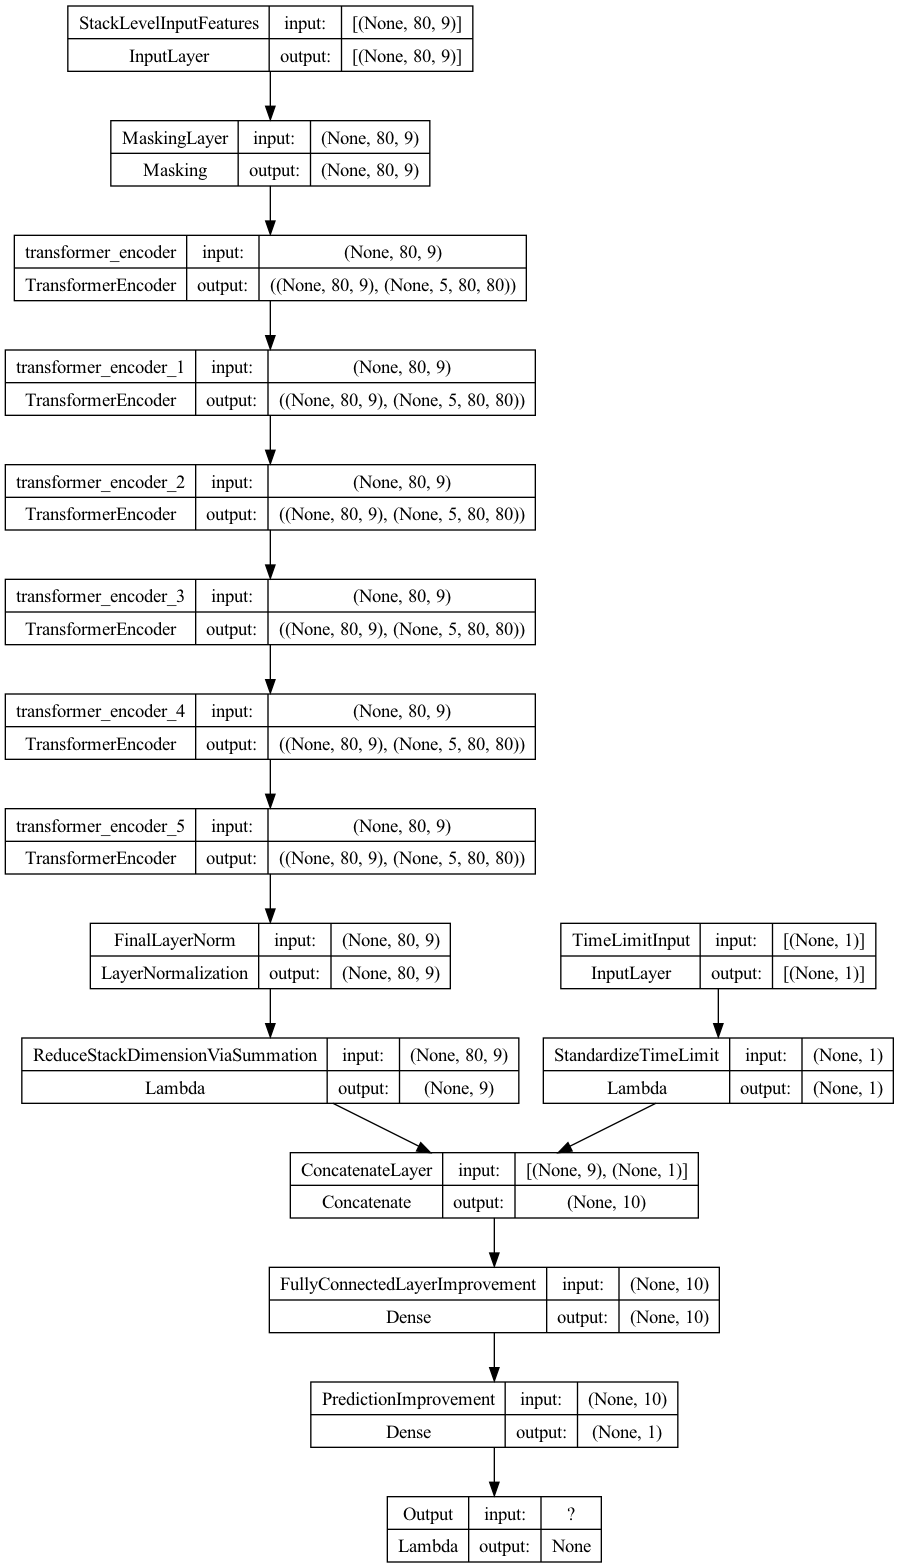

In [20]:
tf.keras.utils.plot_model(
    model,
    #to_file,
    show_shapes=True
)

## Training Process Functions

In [21]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [22]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [23]:
@tf.function
def model_pass(inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            mean_loss(losses)
        
    return outputs


In [24]:
def run_epoch(dataset, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = polars_transformation(X_batch, TARGET_LABELS, shuffle=shuffle)
        
        outputs = model_pass(X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [TARGET_LABELS[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [TARGET_LABELS[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return history

## Model Training

In [25]:
clms = ["Epoch", "Target", "Metric", "Value"]
track = pd.DataFrame(columns = clms)

In [ ]:
n_epochs = 3

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")

    track = run_epoch(train_dataset, all_metrics, epoch=epoch, history=track, training=True, shuffle=True)
    track = run_epoch(val_dataset, all_metrics, epoch=epoch, history=track, training=False, shuffle=True)

    # make an intermediate save of the model
    model_path = os.path.join(cwd, "models", "01_Multitask", f"SOLVED-MODEL-{epoch}.tf")
    model.save(model_path, overwrite=True, save_format="tf")

    print("-"*120)

Epoch 001/003


2023-12-12 22:21:36.353572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 008/177	LR: 0.009970037                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
history = track\
    .pivot_table(
        values = ["Value"],
        columns=["Metric"],
        index=["Epoch", "Target"]
    )\
    .reset_index()\
    .set_index("Epoch", drop=True)

clms = history.columns
history.columns = [clm[i>=1] for i, clm in enumerate(clms)]
history

In [ ]:
clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(16, 9*len(TARGET_LABELS)))

colors = ["cyan", "orange", "blue", "forestgreen", "red", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    # Plot the loss
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    ax[i, 1].set(yscale = "log")

ax[0, 0].set(title="Metrics")
ax[0, 1].set(title="Loss");


Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision

### Visualize Attention Scores:

In [ ]:
from utils.DNN.utils import get_attention_scores

attention = get_attention_scores(model, model_inputs=cx, layer_name="transformer_encoder_15")
attention.shape
#cx[0][24].round(2)[:40]

In [ ]:
instance, head = 24, 3 # 18: 36 # 24 is a very simple but good example

attention_matrix = attention[instance, head, :, :]

# truncate:
n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
attention_matrix = attention_matrix[:n_inputs, :n_inputs]

plt.figure(figsize=(12, 12))
sns.heatmap(attention_matrix.T,
            square=True,
            #vmin=0, vmax=1
           );

In [ ]:
instances = [28, 24, 25, 26]
heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):

        # Truncate
        attention_matrix = attention[instance, head, :, :]
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            #vmin=0, vmax=0.1,
            ax=ax[i, h]
        );

# Load the model to see if it works

In [ ]:
model_path = os.path.join(cwd, "models", f"EncoderUpdate-20.tf")

loaded_model = tf.keras.models.load_model(model_path)
y_pred = loaded_model(cx);

In [ ]:
pred_df = data=pd.DataFrame([y_pred[1].numpy(), cy[1]]).T
pred_df.columns = ["prediction", "improvement"]

sns.histplot(
    data=pred_df,
    x="prediction",
    hue="improvement",
    bins=np.arange(0, 1, 0.02)
);

In [ ]:
test_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = test_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
)

In [ ]:
run_epoch(test_dataset, all_metrics, epoch=epoch, history=track, training=False, shuffle=True)